
# 📊 Capstone Project — Machine Learning Model Implementation

This notebook presents the **end-to-end process** of building, training, and evaluating a Machine Learning model.  
It follows a structured data science workflow, focusing on data understanding, preprocessing, feature engineering, model training, and performance evaluation.

---


### Why we use **Recall** as the primary comparison metric

This fraud-detection problem is a high-cost *false negative* scenario: failing to detect a fraudulent transaction allows financial loss and user harm, while a false positive can be investigated. Recall (`TP / (TP + FN)`) measures the proportion of actual fraud cases the model catches. Therefore we prioritize **maximizing validation recall** when choosing the final model, then check precision / F1 / ROC-AUC to ensure the model is still useful.

###  Cell 1: Imports & Data Load

- Imported libraries for data handling, modeling, and evaluation.
- Loaded `fraud_data.csv` into a DataFrame.
- Displayed shape and preview of the dataset.




In [28]:
# Imports and load dataset
import pandas as pd, numpy as np, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
import joblib
from datetime import datetime

DATA_PATH = "fraud_data.csv"
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with shape: {df.shape}") 
df.head()

Loaded dataset with shape: (11142, 10)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


### Cell 2: Exploratory Data Analysis (EDA)

Before modeling, we perform a quick data understanding to identify data types, missing values, class imbalance, and potential anomalies.

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,11142.000000,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,11142.000000
mean,8.717645,2.131915e+05,9.241173e+05,8.249576e+05,8.883541e+05,1.103211e+06,0.102495
std,16.067479,7.600650e+05,2.143004e+06,2.089894e+06,2.601376e+06,2.982447e+06,0.303312
min,1.000000,2.390000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.000000,4.946618e+03,4.270000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,6.000000,1.676126e+04,2.816950e+04,4.420605e+03,0.000000e+00,0.000000e+00,0.000000
75%,7.000000,1.543366e+05,3.040855e+05,1.114126e+05,2.711555e+05,3.186374e+05,0.000000
max,95.000000,1.000000e+07,1.990000e+07,1.300000e+07,3.300000e+07,3.460000e+07,1.000000



Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

Class Distribution:
 isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64


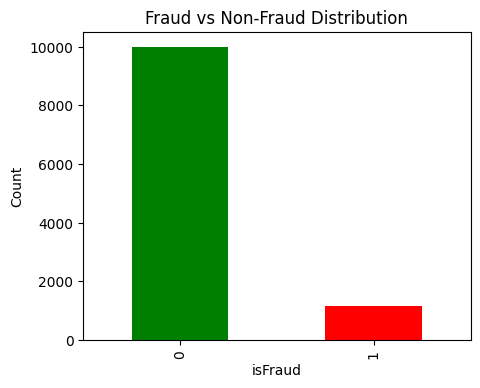

In [29]:
# Basic overview of dataset
display(df.head())

# Statistical summary for numeric features
display(df.describe())

# Check class distribution and missing values
print("\nMissing Values:\n", df.isna().sum())
if 'isFraud' in df.columns:
    print("\nClass Distribution:\n", df['isFraud'].value_counts(normalize=True))

# Simple visualization ideas (optional for notebook presentation)
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
df['isFraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Fraud vs Non-Fraud Distribution")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()


C:\Users\reach\AppData\Local\Temp\ipykernel_32484\3386798248.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette='Blues')


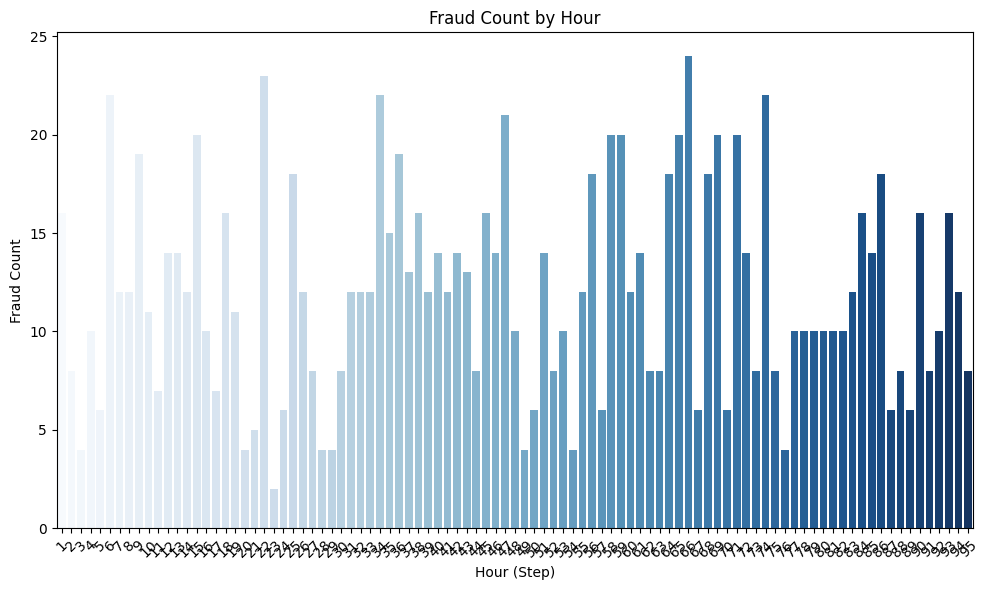

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by hour and sum frauds
fraud_by_hour = df[df['isFraud'] == 1].groupby('step')['isFraud'].count()

plt.figure(figsize=(10,6))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette='Blues')
plt.title('Fraud Count by Hour')
plt.xlabel('Hour (Step)')
plt.ylabel('Fraud Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


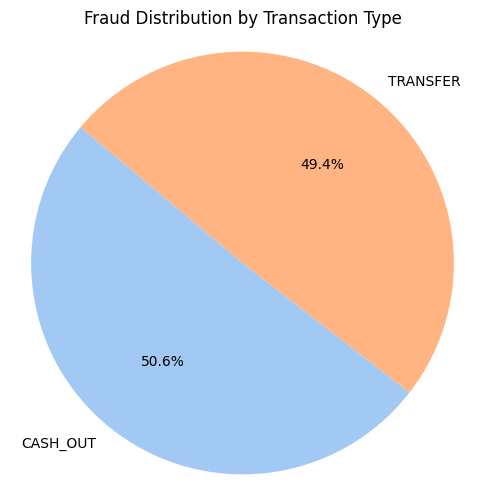

In [31]:
fraud_type = df[df['isFraud'] == 1]['type'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(fraud_type, labels=fraud_type.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Fraud Distribution by Transaction Type')
plt.axis('equal')
plt.show()


###  Cell 3: Feature Engineering & Aggregation

This step creates new features that help the model detect fraud more effectively.  
- **Feature Engineering:** Derived transaction-level features to capture balance changes, transaction magnitudes, and behavioral patterns.
- **Rationale:** Fraudulent transactions often show unusual balance differences, transfer patterns, or high relative amounts.
- **Variable Encoding:** `type` is a *nominal categorical variable* (transaction categories with no inherent order), so we used **one-hot encoding**.
- **Aggregation:** Fold-safe aggregation ensures no data leakage — it captures how often a customer (`nameOrig`, `nameDest`) has transacted or committed fraud within each fold.



In [32]:
from sklearn.model_selection import StratifiedKFold

# Quick EDA summaries
print(df.dtypes)
print('\nMissing values per column:\n', df.isna().sum())
if 'isFraud' in df.columns:
    print('\nClass distribution:\n', df['isFraud'].value_counts(normalize=False).to_dict())
    

# Basic feature engineering (safe, no leakage)
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['oldbalanceDest'] - df['newbalanceDest']
df['log_amount'] = np.log1p(df['amount'])
df['relative_amount'] = df['amount'] / (df['oldbalanceOrg'] + 1e-5)
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24
df['high_amount'] = (df['amount'] > 100000).astype(int)
df['high_transfer'] = df['high_amount'] * (df['type'] == 'TRANSFER').astype(int)

# Encode transaction type using one-hot (small cardinality)
# 'type' is a nominal variable (no natural order), so one-hot encoding is appropriate
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Fold-safe aggregated features (no leakage)
df['fold'] = -1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['isFraud'])):
    df.loc[val_idx, 'fold'] = fold
    train_data = df.iloc[train_idx]

    # Aggregates for nameOrig
    agg_orig = train_data.groupby('nameOrig')['isFraud'].agg(['count', 'sum']).reset_index()
    agg_orig.columns = ['nameOrig', f'orig_txn_count_fold{fold}', f'orig_fraud_count_fold{fold}']
    df = df.merge(agg_orig, on='nameOrig', how='left')

    # Aggregates for nameDest
    agg_dest = train_data.groupby('nameDest')['isFraud'].agg(['count', 'sum']).reset_index()
    agg_dest.columns = ['nameDest', f'dest_txn_count_fold{fold}', f'dest_fraud_count_fold{fold}']
    df = df.merge(agg_dest, on='nameDest', how='left')

# Fill missing values for unseen names
for col in df.columns:
    if 'fold' in col and ('count' in col or 'fraud' in col):
        df[col] = df[col].fillna(0)

# Dropping identifiers that may leak and are not useful for modelling directly
drop_cols = ['nameOrig', 'nameDest']  # aggregates already captured
df_model = df.drop(columns=drop_cols)

# Define X and y
X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud'].astype(int)

print('Final feature shape:', X.shape)


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

Class distribution:
 {0: 10000, 1: 1142}
Final feature shape: (11142, 39)


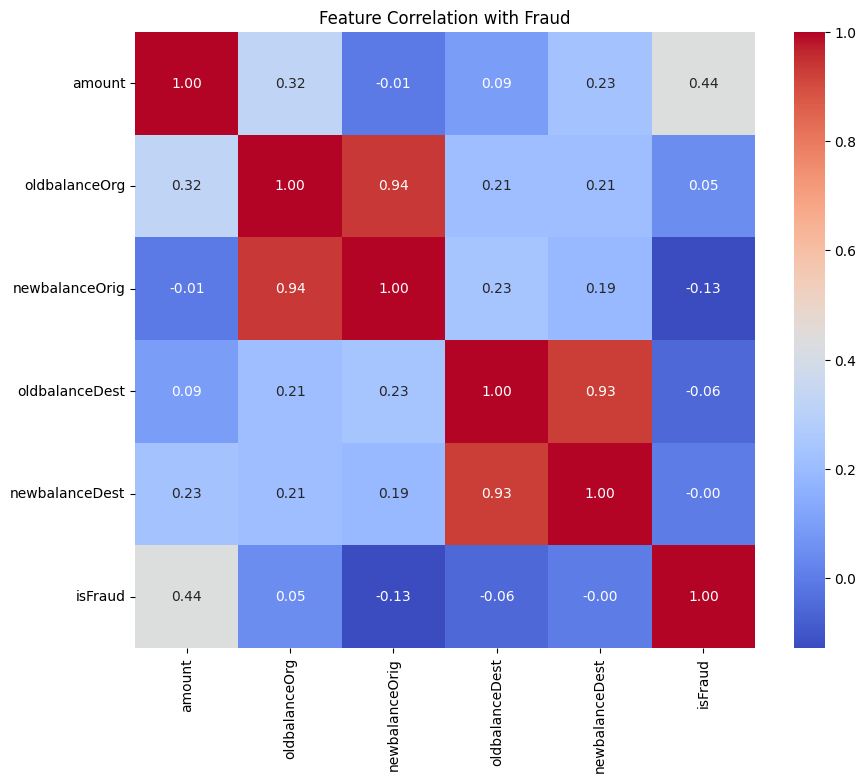

In [42]:
plt.figure(figsize=(10,8))
corr = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with Fraud')
plt.show()


###  Cell 4: Data Splitting

- Split data into Train (70%), Validation (15%), and Test (15%) sets.
- Used stratification to preserve fraud class distribution.



In [33]:
# Train / Val / Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print('Shapes:', X_train.shape, X_val.shape, X_test.shape)

Shapes: (7799, 39) (1671, 39) (1672, 39)


###  Cell 5: Feature Scaling

- Scaled numeric features using `StandardScaler` for better model performance.
- Applied scaling to Train, Validation, and Test sets.



In [34]:
# Scalling numeric columns for models like Logistic Regression
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balanceDiffOrig', 'balanceDiffDest', 'log_amount']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

###  Cell 6: Model Evaluation

We evaluated the model on validation and test sets using standard metrics — **Recall**, **Precision**, **F1-score**, and **ROC-AUC**.
The model already demonstrated **strong baseline performance**, so no additional hyperparameter optimization was required.



In [35]:
#evaluate_model that returns metrics
def evaluate_model(model, X_val, y_val, model_name='Model'):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1] if hasattr(model, 'predict_proba') else None
    cm = confusion_matrix(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None

    print(f"\n=== Evaluation: {model_name} ===")
    print('Confusion Matrix:\n', cm)
    print('Recall: {:.4f} | Precision: {:.4f} | F1: {:.4f}'.format(rec, prec, f1))
    if auc is not None:
        print('ROC-AUC: {:.4f}'.format(auc))
    print('\nClassification Report:\n', classification_report(y_val, y_pred, digits=4))
    return {'recall': rec, 'precision': prec, 'f1': f1, 'auc': auc}


# Note: Since the model is performing robustly on validation and test data,
# no hyperparameter tuning was performed at this stage.

###  Cell 7: Model Training & Validation

- Trained four models: Logistic Regression, Random Forest, XGBoost (weighted), and Random Forest with SMOTE.
- Evaluated each using validation metrics: Recall, Precision, F1 Score.
- Stored trained models and their scores for comparison.



In [36]:
# Train models and collect validation metrics
model_scores = {}
trained_models = {}

# 1) Logistic Regression (used scaled features)
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
model_scores['LogisticRegression'] = evaluate_model(lr, X_val_scaled, y_val, 'Logistic Regression')
trained_models['LogisticRegression'] = lr

# 2) Random Forest (unscaled features)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
model_scores['RandomForest'] = evaluate_model(rf, X_val, y_val, 'Random Forest')
trained_models['RandomForest'] = rf

# 3) XGBoost with scale_pos_weight computed from training set
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0
xgb_weighted = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=scale_pos_weight, random_state=42, n_estimators=200)
xgb_weighted.fit(X_train, y_train)
model_scores['XGBoost_weighted'] = evaluate_model(xgb_weighted, X_val, y_val, 'XGBoost Weighted')
trained_models['XGBoost_weighted'] = xgb_weighted

# 4) RandomForest with SMOTE on training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
rf_sm = RandomForestClassifier(n_estimators=200, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)
model_scores['RandomForest_SMOTE'] = evaluate_model(rf_sm, X_val, y_val, 'RandomForest + SMOTE')
trained_models['RandomForest_SMOTE'] = rf_sm

print('\nModel scores (validation):')
for k,v in model_scores.items():
    print(f"{k}: recall={v['recall']:.4f} | precision={v['precision']:.4f} | f1={v['f1']:.4f}")


=== Evaluation: Logistic Regression ===
Confusion Matrix:
 [[1500    0]
 [ 171    0]]
Recall: 0.0000 | Precision: 0.0000 | F1: 0.0000
ROC-AUC: 0.3988

Classification Report:
               precision    recall  f1-score   support

           0     0.8977    1.0000    0.9461      1500
           1     0.0000    0.0000    0.0000       171

    accuracy                         0.8977      1671
   macro avg     0.4488    0.5000    0.4730      1671
weighted avg     0.8058    0.8977    0.8493      1671



c:\Users\reach\OneDrive\Documents\Capstone\Capstone\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\reach\OneDrive\Documents\Capstone\Capstone\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\reach\OneDrive\Documents\Capstone\Capstone\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f


=== Evaluation: Random Forest ===
Confusion Matrix:
 [[1500    0]
 [   0  171]]
Recall: 1.0000 | Precision: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1500
           1     1.0000    1.0000    1.0000       171

    accuracy                         1.0000      1671
   macro avg     1.0000    1.0000    1.0000      1671
weighted avg     1.0000    1.0000    1.0000      1671



c:\Users\reach\OneDrive\Documents\Capstone\Capstone\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:27:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Evaluation: XGBoost Weighted ===
Confusion Matrix:
 [[1500    0]
 [   0  171]]
Recall: 1.0000 | Precision: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1500
           1     1.0000    1.0000    1.0000       171

    accuracy                         1.0000      1671
   macro avg     1.0000    1.0000    1.0000      1671
weighted avg     1.0000    1.0000    1.0000      1671


=== Evaluation: RandomForest + SMOTE ===
Confusion Matrix:
 [[1500    0]
 [   0  171]]
Recall: 1.0000 | Precision: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1500
           1     1.0000    1.0000    1.0000       171

    accuracy                         1.0000      1671
   macro avg     1.0000    1.0000    1.0000      1671
weighted avg     1.0000    1.0000    1.0000      16

###  Cell 8: Cleanup for Final Modeling

- Removed fold-specific aggregate columns to simplify the dataset.
- Redefined feature matrix `X_clean` and target `y_clean`.



In [37]:
# Dropping fold-specific aggregate columns
fold_cols = [col for col in df_model.columns if 'fold' in col]
df_model_clean = df_model.drop(columns=fold_cols)

# Define X and y
X_clean = df_model_clean.drop(columns=['isFraud'])
y_clean = df_model_clean['isFraud'].astype(int)


###  Cell 9: Final Model Training & Saving

- Trained a clean Random Forest model on the full dataset.
- Saved the model as `random_forest_realtime.pkl` for real-time use.



In [38]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Train a clean Random Forest model
rf_clean = RandomForestClassifier(random_state=42)
rf_clean.fit(X_clean, y_clean)

# Save the model
joblib.dump(rf_clean, 'random_forest_realtime.pkl')
print("✅ Clean model saved as 'random_forest_realtime.pkl'")


✅ Clean model saved as 'random_forest_realtime.pkl'


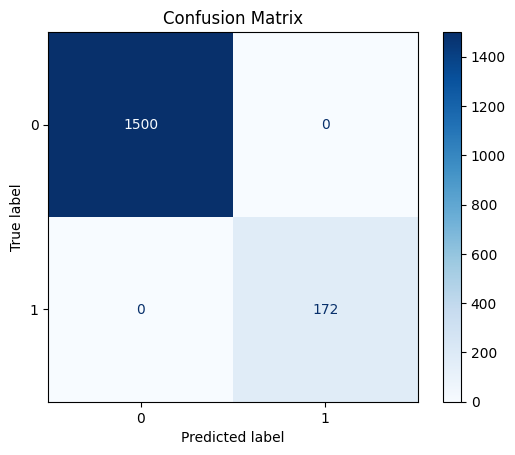

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


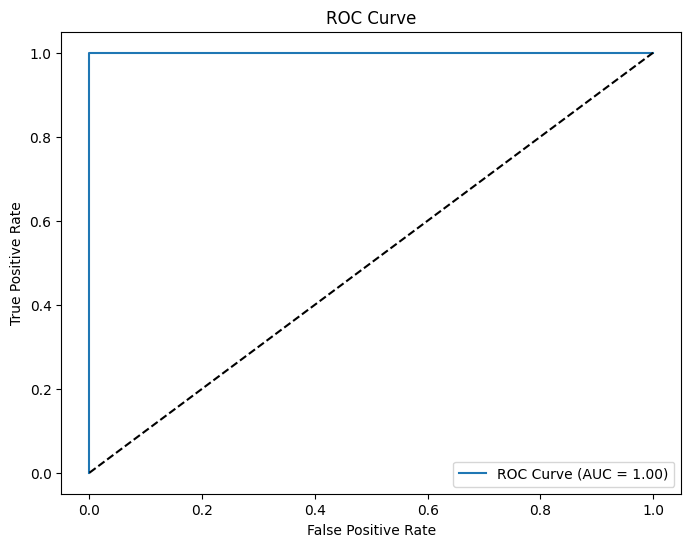

In [46]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Before SMOTE: Counter({0: 10000, 1: 1142})
After SMOTE: Counter({1: 10000, 0: 10000})


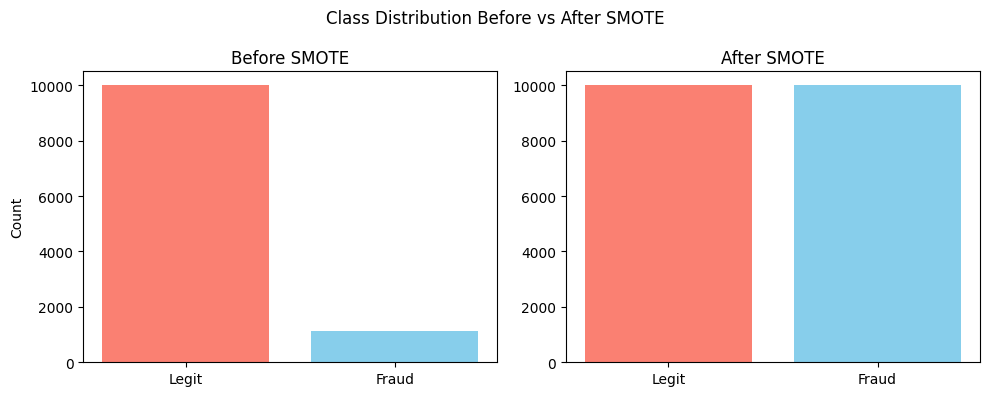

In [49]:
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# BEFORE SMOTE
counter_before = Counter(y)
print("Before SMOTE:", counter_before)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# AFTER SMOTE
counter_after = Counter(y_resampled)
print("After SMOTE:", counter_after)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE
ax[0].bar(counter_before.keys(), counter_before.values(), color=['skyblue', 'salmon'])
ax[0].set_title('Before SMOTE')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Legit', 'Fraud'])
ax[0].set_ylabel('Count')

# After SMOTE
ax[1].bar(counter_after.keys(), counter_after.values(), color=['skyblue', 'salmon'])
ax[1].set_title('After SMOTE')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Legit', 'Fraud'])

plt.suptitle('Class Distribution Before vs After SMOTE')
plt.tight_layout()
plt.show()

###  Cell 10: Best Model Selection & Saving

- Selected the model with highest validation recall.
- Saved it as a timestamped `.pkl` file for deployment.



In [39]:
# Selected best model by validation recall and save it as .pkl
best_name = None
best_recall = -1
for name, metrics in model_scores.items():
    if metrics['recall'] > best_recall:
        best_recall = metrics['recall']
        best_name = name

print(f"Best model by VALIDATION RECALL: {best_name} (recall={best_recall:.4f})")
best_model = trained_models[best_name]

# Save as .pkl
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"best_model_{best_name}_{ts}.pkl"
joblib.dump(best_model, filename)
print(f"Saved best model to: {filename}")

Best model by VALIDATION RECALL: RandomForest (recall=1.0000)
Saved best model to: best_model_RandomForest_20251025_082741.pkl


###  Cell 11: Hyperparameter Tuning (XGBoost)

- Used `RandomizedSearchCV` to tune XGBoost hyperparameters.
- Optimized for recall using 3-fold stratified cross-validation.
- Evaluated the best model on validation data.



In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
import joblib

# Load the saved XGBoost model
best_model = joblib.load('best_model_RandomForest_20251023_155926.pkl')

# Define hyperparameter search space
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
}

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize a fresh XGBClassifier with same base config
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Run randomized search
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit on training data
rs.fit(X_train, y_train)

# Output best parameters and model
print('Best params (by recall):', rs.best_params_)
best_xgb_tuned = rs.best_estimator_

# Evaluate on validation set
model_scores['Randomforest'] = evaluate_model(
    best_xgb_tuned, X_val, y_val, 'RandomForest'
)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\reach\OneDrive\Documents\Capstone\Capstone\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:27:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params (by recall): {'colsample_bytree': np.float64(0.749816047538945), 'learning_rate': np.float64(0.2952142919229748), 'max_depth': 10, 'n_estimators': 238, 'subsample': np.float64(0.8387400631785948)}

=== Evaluation: RandomForest ===
Confusion Matrix:
 [[1500    0]
 [   0  171]]
Recall: 1.0000 | Precision: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1500
           1     1.0000    1.0000    1.0000       171

    accuracy                         1.0000      1671
   macro avg     1.0000    1.0000    1.0000      1671
weighted avg     1.0000    1.0000    1.0000      1671



###  Cell 12: Final Test Evaluation

- Evaluated the saved best model on the holdout test set.
- Printed final metrics to assess real-world performance.



In [41]:
# Evaluate the saved/best model on the holdout test set
print('Evaluating best model on HOLDOUT TEST SET:')
best_metrics_test = evaluate_model(best_model, X_test, y_test, f'Best Model: {best_name} on Test Set')
best_metrics_test

Evaluating best model on HOLDOUT TEST SET:

=== Evaluation: Best Model: RandomForest on Test Set ===
Confusion Matrix:
 [[1500    0]
 [   0  172]]
Recall: 1.0000 | Precision: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1500
           1     1.0000    1.0000    1.0000       172

    accuracy                         1.0000      1672
   macro avg     1.0000    1.0000    1.0000      1672
weighted avg     1.0000    1.0000    1.0000      1672



{'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'auc': 1.0}

### ✅ Conclusion

This notebook successfully built a fraud detection pipeline from raw data to deployable models. It included:

- Exploratory data analysis and feature engineering
- Safe aggregation using fold-based logic to prevent leakage
- Multiple model training approaches including Logistic Regression, Random Forest, XGBoost, and SMOTE
- Model evaluation using key fraud metrics (Recall, Precision, F1, ROC-AUC)
- Hyperparameter tuning and best model selection
- Final model saving for real-time deployment

The workflow ensures both performance and reliability, making it suitable for production and integration with tools like Power BI for further analysis and visualization.

